# Wind Analysis

### Script to extract ERA wind data from google earth engine and calculate average windspeed and direction for locations of interest

Working as of 11 Oct 2022 \
Using seagrass locations with 10k buffer \
Monthly ERA5 wind data - can change to daily if needed but exceeds memory limits easily

In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geemap
import geopandas as gpd

In [2]:
#ee.Authenticate()
ee.Initialize()

In [3]:
#import full sg csv and convert into suitable format
path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass Carbon Data\Notebooks\MASTER_carbon_dataset2_locations_validated.csv"
sg_df_full = pd.read_csv(path)
#sg_df_full

#keep columns Dataset_ID, Site_name, Lat, Long, Cstock25_Mgha
sg_df = sg_df_full[['Dataset_ID', 'Site_name', 'Lat', 'Long']]
sg_df = sg_df.rename(columns = {'Long':'x', 'Lat':'y'})
#remove any rows with nas in x or y
sg_df = sg_df.dropna(subset=['x'])
sg_df.shape

(217, 4)

In [4]:
#convert to geopandas dataframe
from pandas_geojson import to_geojson
sg_json2 = to_geojson(df=sg_df, lat='y', lon='x',
                 properties=['Dataset_ID','Site_name'])

In [5]:
#print(sg_json2)
sg_fc = ee.FeatureCollection(sg_json2)
sg_fc.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-122.477643, 48.315253]},
 'id': '0',
 'properties': {'Dataset_ID': 'ID_101', 'Site_name': 'Skagit Bay'}}

In [6]:
#use this one for short cornwall only sg csv
#path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass Carbon Data\Notebooks\sg_df_cornwall_short.csv"
#sg_df = pd.read_csv(path)
#sg_df

#convert lat and long to xy
#sg_df['x'] = sg_df['Long']
#sg_df['y'] = sg_df['Lat']
#sg_df.drop(['Lat', 'Long', 'geometry'], axis = 1, inplace = True)
#sg_df.to_csv('sg_csv.csv')

In [7]:
#chop and rename sg_df
#convert lat and long to xy

#sg_df.to_csv('sg_csv.csv')

### Functions to calculate bands

In [8]:
#function to calculate windspeed as a band
def windspeed(image):
    wind_10m = image.expression('sqrt(u**2 + v**2)', {
        'u': image.select('u_component_of_wind_10m'),
        'v': image.select('v_component_of_wind_10m')
      }).rename('windspeed')
    time = image.get('system:time_start')

    return wind_10m.set('system:time_start', time)

In [9]:
#function to calculate wind direction as a band
def wind_dir(image):
    winddir = image.expression(
        'mod(180 + (180/3.14) * atan2(v,u), 360)', {
          'u': image.select('u_component_of_wind_10m'),
          'v': image.select('v_component_of_wind_10m')
        }).rename('winddir')
    time = image.get('system:time_start')
    
    return winddir.set('system:time_start', time)


### GEE wind data analysis

In [10]:
#set up
ERA5 = ee.ImageCollection("ECMWF/ERA5/DAILY")

#Define start and end periods
start_period = ee.Date('2017-01-01')
end_period = ee.Date('2020-01-01')

#filter dataset to start and end period
ERA5 = ERA5.filter(ee.Filter.date(start_period, end_period))

#add windspeed and wind direction bands to dataset
ERA5windspeed = ERA5.map(windspeed)
ERA5winddir = ERA5.map(wind_dir)

In [11]:
#function to calculate average windspeed in buffer area
def mean_speed(image): 
    meanDict = image.select('windspeed').reduceRegions(
        collection = buffers,
        reducer = ee.Reducer.mean(),
        scale = 27830)
    return meanDict

In [12]:
#function to calculate average wind direction in buffer area
def mean_dir(image):
    meanDict = image.select('winddir').reduceRegions(
        collection = buffers,
        reducer = ee.Reducer.mean(),
        scale = 27830
  )
    return meanDict

In [13]:
#if want to trial on a short df
#sg_df = sg_df.loc[0:2,:]

In [14]:
#create geometry column and gpd df and convert to ee feature collection
#sg_gdf = gpd.GeoDataFrame(
    #sg_df, geometry=gpd.points_from_xy(x=sg_df.x, y=sg_df.y, crs=('EPSG:4326'))
#)

In [15]:
#sg_gdf

#define functionto convert geopandas to feature collection as geemap function not working
import numpy as np
from functools import reduce
from geopandas import GeoDataFrame
from shapely.geometry import Point,Polygon

def make_points(gdf):
    g = [i for i in gdf.geometry]
    features=[]
    for i in range(len(g)):
        g = [i for i in gdf.geometry]
        x,y = g[i].coords.xy
        cords = np.dstack((x,y)).tolist()
        double_list = reduce(lambda x,y: x+y, cords)
        single_list = reduce(lambda x,y: x+y, double_list)

        g=ee.Geometry.Point(single_list)
        feature = ee.Feature(g)
        features.append(feature)
        #print("done")
        ee_object = ee.FeatureCollection(features)
    
    return ee_object

#fc = make_points(sg_gdf)
import json
#import os
#import requests
from geemap import geojson_to_ee, ee_to_geojson
sg_json = sg_gdf.to_json()
sg_fc2 = ee.FeatureCollection(sg_json)
sg_fc3 = geojson_to_ee(sg_json)

In [16]:
#apply function to the sg geodataframe
#sg_fc = make_points(sg_gdf)

In [17]:
#check seagrass locations using geemap to visualise
#Map = geemap.Map()
#Map.addLayer(sg_fc, {}, 'seagrass')
#Map

In [18]:
#run loop to extract windspeed for each site and put into a dictionary of dataframes

def addBuffer(feature):
    return feature.buffer(10000)
buffers = sg_fc.map(addBuffer)
    
#map functions to average wind speed and direction across buffer geometry
ERA5meanspeed = ERA5windspeed.map(mean_speed).flatten()
ERA5meandir = ERA5winddir.map(mean_dir).flatten()

#export data into a dataframe
#convert bands into arrays
time = ERA5meanspeed.aggregate_array('system:index').getInfo()
windspeed = ERA5meanspeed.aggregate_array('mean').getInfo()
winddir = ERA5meandir.aggregate_array('mean').getInfo()
site_name = ERA5meandir.aggregate_array('Site_name').getInfo()
Dataset_ID = ERA5meanspeed.aggregate_array('Dataset_ID').getInfo()

#time_dir = ERA5meandir.aggregate_array('system:index').getInfo() #check that the times match
#site_name_sp = ERA5meanspeed.aggregate_array('Site_name').getInfo()
#run time == time_dir and site_name == site_name_sp to check they are the same order (==TRUE)

#combine arrays into dataframe

windspeed_out = pd.DataFrame ({'time':time,'windspeed':windspeed, 'winddir':winddir, 'site_name':site_name, 'Dataset_ID':Dataset_ID})
#windspeed_out = pd.DataFrame ({'Dataset_ID':Dataset_ID})

#add location in for reference to which seagrass site
#windspeed_out['x'] = list(geometry.getInfo().values())[1][0]
#windspeed_out['y'] = list(geometry.getInfo().values())[1][1]

##wind_data[name] = windspeed_out

In [19]:
windspeed_out

,time,windspeed,winddir,site_name,Dataset_ID
0,20170101_0,2.313824,24.537280,Skagit Bay,ID_101
1,20170101_1,2.313824,24.537280,Skagit Bay,ID_102
2,20170101_2,3.421227,19.065492,Padilla Bay,ID_103
3,20170101_3,3.421227,19.065492,Padilla Bay,ID_104
4,20170101_4,3.166846,19.192649,Padilla Bay,ID_105
...,...,...,...,...,...
237610,20191231_212,5.905985,295.983262,Gelting_LH,ID_321
237611,20191231_213,3.040839,110.100195,Wilcove,ID_322
237612,20191231_214,3.038590,109.983643,Thanckes Lake,ID_323
237613,20191231_215,3.455934,107.441266,Collapit Creek,ID_324


In [20]:
wind_data = {x: windspeed_out.loc[windspeed_out['Dataset_ID'] == x].drop('Dataset_ID', axis=1) for x in windspeed_out['Dataset_ID'].unique()}

In [21]:
#view data
wind_data.keys()

dict_keys(['ID_101', 'ID_102', 'ID_103', 'ID_104', 'ID_105', 'ID_106', 'ID_107', 'ID_108', 'ID_109', 'ID_110', 'ID_111', 'ID_112', 'ID_113', 'ID_114', 'ID_115', 'ID_116', 'ID_117', 'ID_118', 'ID_119', 'ID_120', 'ID_121', 'ID_122', 'ID_123', 'ID_124', 'ID_125', 'ID_126', 'ID_127', 'ID_128', 'ID_129', 'ID_130', 'ID_131', 'ID_132', 'ID_133', 'ID_134', 'ID_135', 'ID_136', 'ID_137', 'ID_138', 'ID_139', 'ID_140', 'ID_141', 'ID_142', 'ID_143', 'ID_144', 'ID_145', 'ID_146', 'ID_147', 'ID_148', 'ID_149', 'ID_150', 'ID_151', 'ID_152', 'ID_153', 'ID_155', 'ID_156', 'ID_157', 'ID_158', 'ID_159', 'ID_160', 'ID_161', 'ID_162', 'ID_163', 'ID_164', 'ID_165', 'ID_166', 'ID_167', 'ID_168', 'ID_169', 'ID_170', 'ID_171', 'ID_172', 'ID_173', 'ID_174', 'ID_175', 'ID_176', 'ID_177', 'ID_178', 'ID_179', 'ID_180', 'ID_181', 'ID_182', 'ID_183', 'ID_184', 'ID_185', 'ID_186', 'ID_187', 'ID_188', 'ID_189', 'ID_190', 'ID_191', 'ID_192', 'ID_193', 'ID_195', 'ID_196', 'ID_198', 'ID_199', 'ID_200', 'ID_201', 'ID_202',

In [22]:
wind_data['ID_101']

,time,windspeed,winddir,site_name
0,20170101_0,2.313824,24.537280,Skagit Bay
217,20170102_0,6.179069,32.791870,Skagit Bay
434,20170103_0,4.570756,44.925909,Skagit Bay
651,20170104_0,4.269885,43.533622,Skagit Bay
868,20170105_0,1.464498,54.529900,Skagit Bay
...,...,...,...,...
236530,20191227_0,5.673062,140.831759,Skagit Bay
236747,20191228_0,3.729770,119.535726,Skagit Bay
236964,20191229_0,2.856734,98.255692,Skagit Bay
237181,20191230_0,2.074848,143.036017,Skagit Bay


## Iterate over whole dictionary

In [23]:
wind_data['ID_101']
#wind_data.keys()

,time,windspeed,winddir,site_name
0,20170101_0,2.313824,24.537280,Skagit Bay
217,20170102_0,6.179069,32.791870,Skagit Bay
434,20170103_0,4.570756,44.925909,Skagit Bay
651,20170104_0,4.269885,43.533622,Skagit Bay
868,20170105_0,1.464498,54.529900,Skagit Bay
...,...,...,...,...
236530,20191227_0,5.673062,140.831759,Skagit Bay
236747,20191228_0,3.729770,119.535726,Skagit Bay
236964,20191229_0,2.856734,98.255692,Skagit Bay
237181,20191230_0,2.074848,143.036017,Skagit Bay


In [24]:
#add in a bearings column with the bearing grouping
bearings_dict = {}
for key, df in wind_data.items(): 
    #print(wind_data[key].iloc[0]['winddir'])
    #print(df.iloc[0]['winddir']) #prints first value in each dataframe in the winddir column
           
    conditions = [
        (df['winddir'] <= 22.5),
        (df['winddir'] > 22.5) & (df['winddir'] <= 45),
        (df['winddir'] > 45) & (df['winddir'] <= 67.5),
        (df['winddir'] > 67.5) & (df['winddir'] <= 90),
        (df['winddir'] > 90) & (df['winddir'] <= 112.5),
        (df['winddir'] > 112.5) & (df['winddir'] <= 135),
        (df['winddir'] > 135) & (df['winddir'] <= 157.5),
        (df['winddir'] > 157.5) & (df['winddir'] <= 180),
        (df['winddir'] > 180) & (df['winddir'] <= 202.5),
        (df['winddir'] > 202.5) & (df['winddir'] <= 225),
        (df['winddir'] > 225) & (df['winddir'] <= 247.5),
        (df['winddir'] > 247.5) & (df['winddir'] <= 270),
        (df['winddir'] > 270) & (df['winddir'] <= 292.5),
        (df['winddir'] > 292.5) & (df['winddir'] <= 315),
        (df['winddir'] > 315) & (df['winddir'] <= 337.5),
        (df['winddir'] > 337.5)]
    bearings = np.arange(0,360,22.5)
    df['bearings'] = np.select(conditions, bearings)
    
    bearings_dict[key] = df

#for i in wind_data.keys():
    #print(i)
    #print(wind_data[i].iloc[0]['winddir'])

In [25]:
bearings_dict['ID_101']

,time,windspeed,winddir,site_name,bearings
0,20170101_0,2.313824,24.537280,Skagit Bay,22.5
217,20170102_0,6.179069,32.791870,Skagit Bay,22.5
434,20170103_0,4.570756,44.925909,Skagit Bay,22.5
651,20170104_0,4.269885,43.533622,Skagit Bay,22.5
868,20170105_0,1.464498,54.529900,Skagit Bay,45.0
...,...,...,...,...,...
236530,20191227_0,5.673062,140.831759,Skagit Bay,135.0
236747,20191228_0,3.729770,119.535726,Skagit Bay,112.5
236964,20191229_0,2.856734,98.255692,Skagit Bay,90.0
237181,20191230_0,2.074848,143.036017,Skagit Bay,135.0


In [26]:
#calculate the average windspeed in each bearing direction
x = np.arange(0,365,22.5) #defines bins up to 360 for the value_counts calculation 
speed_freq_dict = {}
for key, df in bearings_dict.items():
    windspeed = df.groupby(by = 'bearings')['windspeed'].mean()
    wind_freq = df['winddir'].value_counts(bins = x, normalize = True).sort_index(ascending = True)

    #convert to dfs and tidy up ready to merg
    wind_freq = pd.DataFrame(wind_freq)
    #print(wind_freq)
    #wind_freq['bearings'] = bearings
    wind_freq.rename(columns = {'winddir': 'wind_freq'}, inplace = True)
    #print(x)
    bearings = np.arange(0,360,22.5)
    wind_freq['bearings'] = bearings
    wind_freq.reset_index(drop = True, inplace = True)
    #print(wind_freq)
    windspeed = pd.DataFrame(windspeed)
    windspeed.reset_index(inplace = True)
    
    windspeed_freq = pd.merge(windspeed, wind_freq, on= 'bearings')
    #windspeed_freq = windspeed_freq.drop(['key_0'], axis =1)
    speed_freq_dict[key] = windspeed_freq


In [27]:
speed_freq_dict['ID_101']

,bearings,windspeed,wind_freq
0,0.0,2.325252,0.024658
1,22.5,2.439559,0.043836
2,45.0,1.664273,0.030137
3,67.5,1.806089,0.023744
4,90.0,2.091719,0.074886
5,112.5,3.275684,0.077626
6,135.0,4.806727,0.155251
7,157.5,2.652693,0.060274
8,180.0,2.335409,0.062100
9,202.5,2.353000,0.106849


# Import fetch data

In [28]:
fetch_path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1_Environmental_variables\R\Final_fetch_calc\outputs\final_outputs\final_fetch_all.csv"
fetch = pd.read_csv(fetch_path) 
#fetch

#### see seperate function "multiple csv into df" to concat all fetch dfs and reruns into final fetch to be imported here


In [29]:
fetch.shape

(217, 21)

In [30]:
#path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1_Environmental_variables\R\Arc_R_binding\Outputs\waver_fetch_df.csv"
#fetch = pd.read_csv(path) 

all_dict = {}
final_dict = {}

for key, df in speed_freq_dict.items():
    #ID = key
    fetch_df = fetch[fetch['Dataset_ID'] == key]
    #print(fetch_df)
    fetch_df = fetch_df.iloc[0,5:]
    
    fetch_df = pd.DataFrame(fetch_df)
    fetch_df.reset_index(inplace = True)
    fetch_df.rename(columns={fetch_df.columns[1]: "fetch_m", fetch_df.columns[0]:"bearings"}, inplace = True)
    fetch_df=fetch_df.astype(float)
    #print(fetch_df)
    
    all_df = pd.merge(df, fetch_df, on = 'bearings')
    all_dict[key] = all_df

for key, df in all_dict.items():
    #df = df.drop(['key_0'], axis=1)
    #df = df.drop(['bearings_y'], axis = 1)
    df.rename(columns={df.columns[0]: "bearings" }, inplace = True)
    final_dict[key] = df

In [31]:
final_dict['ID_103']

,bearings,windspeed,wind_freq,fetch_m
0,0.0,2.773503,0.027397,2732.042856
1,22.5,3.813057,0.066667,2348.798355
2,45.0,2.644499,0.031050,2774.220327
3,67.5,2.039457,0.024658,2609.193814
4,90.0,2.494628,0.032877,2415.588679
5,112.5,3.257449,0.042922,3508.593403
6,135.0,4.913524,0.115982,4662.790206
7,157.5,4.160489,0.093151,9534.869504
8,180.0,3.323328,0.196347,7731.322522
9,202.5,2.744471,0.152511,2539.530796


In [32]:
#fetch.loc[5,:]

In [33]:
#dropping the test columns
#for key, df in bearings_dict.items():
    #df = df.drop(['test'], axis=1)
    #new_dict[key] = df

In [34]:
#calculate the product of windspeed, winddir and fetch on each line
product = {}

for key, df in final_dict.items():
    df['product'] = df.windspeed *df.wind_freq * df.fetch_m
    product[key] = df

In [35]:
product['ID_101']

,bearings,windspeed,wind_freq,fetch_m,product
0,0.0,2.325252,0.024658,3984.635639,228.458995
1,22.5,2.439559,0.043836,3875.819611,414.478459
2,45.0,1.664273,0.030137,3536.683985,177.386539
3,67.5,1.806089,0.023744,4581.228391,196.462742
4,90.0,2.091719,0.074886,5764.446154,902.943590
5,112.5,3.275684,0.077626,7108.274106,1807.469722
6,135.0,4.806727,0.155251,8468.344695,6319.501493
7,157.5,2.652693,0.060274,5972.975525,955.009133
8,180.0,2.335409,0.062100,6960.724548,1009.513673
9,202.5,2.353000,0.106849,7542.108229,1896.209789


In [36]:
#function to sum up the product column for an exposure score
def sum_up(df):
    total = 0
    for number in df['product']:
        total = total + number
        
    return total

In [37]:
exposure = {}
#returns a dictionary of site name and exposure value
for key, df in product.items():
    exp = sum_up(df)  #run the function to sum up the product column
    exp = round(exp,2)  #round to two decimal places 
    exposure[key] = exp #save to a new dictionary

In [38]:
#exposure

In [39]:
ex_df = pd.DataFrame.from_dict(exposure, orient = 'index')

In [40]:
ex_df.rename(columns={ex_df.columns[0]: 'exposure'}, inplace = True)
ex_df.sort_values(by=['exposure'], ascending = False)

,exposure
ID_234,346618.82
ID_139,128965.57
ID_316,122191.38
ID_310,119041.21
ID_135,117392.67
...,...
ID_291,547.62
ID_172,425.19
ID_183,425.19
ID_192,394.89


In [41]:
#match ID and site name back together in final output
final_exp = pd.merge(ex_df, fetch[['Dataset_ID', 'Site_name']], left_index=True, right_on='Dataset_ID')

In [42]:
final_exp.sort_values('exposure')

,exposure,Dataset_ID,Site_name
75,391.47,ID_191,Kennedy Cove IT
76,394.89,ID_192,Kennedy Cove ST
107,425.19,ID_183,"Orleans, MA"
98,425.19,ID_172,"Orleans, MA"
0,547.62,ID_291,Newport Bay
...,...,...,...
118,117392.67,ID_135,Tomb Rock
182,119041.21,ID_310,Teichhof
188,122191.38,ID_316,Kellenhusen
122,128965.57,ID_139,Jennycliff Bay


In [43]:
#save to csv
final_exp.to_csv('outputs\\final_exposure.csv', index = False) 

<AxesSubplot:>

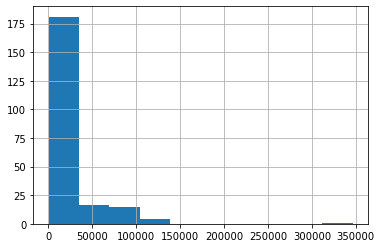

In [44]:
final_exp.exposure.hist()

In [47]:
final_exp.min()

exposure        391.47
Dataset_ID      ID_101
Site_name     Agero 12
dtype: object

In [48]:
final_exp.max()

exposure      346618.82
Dataset_ID       ID_325
Site_name         Ängsö
dtype: object

In [ ]:
f